In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools
using DSP

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools

In [3]:
using BAT 

In [4]:
function eval_conv(conv_matrix, ind)
    ind = convert.(Int64, ind)
    y_tmp = exp.(conv_matrix[:, ind[1]+1])
    for ind_tmp in ind[2:end]
        y_tmp = conv(y_tmp, exp.(conv_matrix[:, ind_tmp+1]))
    end
    prepend!(y_tmp, repeat([0], length(ind)-1))
end

function eval_quantile(conv_matrix, ind; alpha_min = 0.025, alpha_max = 0.975)
    vals = eval_conv(conv_matrix, ind)
    vals_up = argmin(abs.(cumsum(vals) .- alpha_max)) 
    vals_down = argmin(abs.(cumsum(vals) .- alpha_min))
    return (vals_down, vals_up)
end

function eval_conv_is(ind, lf)
    mue = sum(ind)
    sigma = sqrt(sum((lf .* sqrt.(ind)).^2))
    return truncated(Normal(mue, sigma), 0, Inf)
end

nansum(x) = sum(x[.!isnan.(x)])

nansum (generic function with 1 method)

# Low `p` Population: 

In [ ]:
# conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-1.jld2")

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# )

# images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
# event_number = 343

# # Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );

# High `p` Population: 

In [5]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2");
event_number = 2

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


images = load("../data/experiment/dataset_2/m2/images.jld2");

event_nt = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


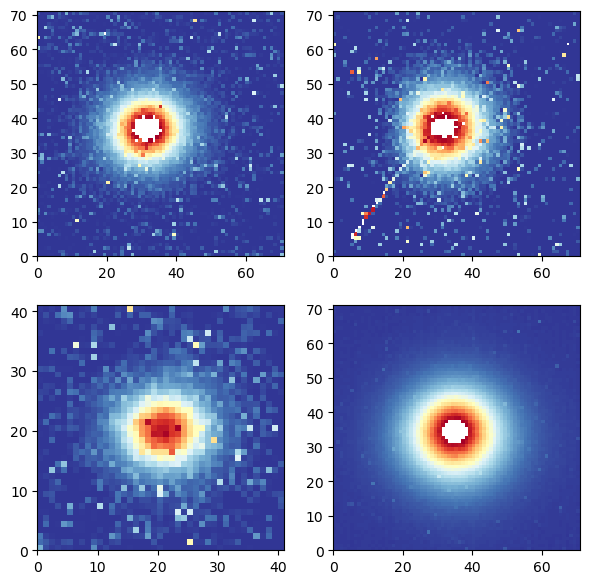

PyObject <matplotlib.collections.QuadMesh object at 0x7f9fe9b53fa0>

In [6]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [7]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

In [8]:
# β = 0.015

β1 = 0.015
β2 = 0.008
β3 = 0.006

# flat prior for the pixel size
prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
        waist = [Normal(2.9, 0.03)],
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
        psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
        psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
        cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
        cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); 

## Load Samples: 

In [9]:
smpl = bat_read("../data/sampling_results/LongRun/hc-2.hdf5")
samples = varshape(prior).(smpl);

In [10]:
mode_params = mode(samples)

ShapedAsNT((tr_size = [0.1425291216654245, 0.1306170428298254], ang_spr = [3.9109811350414296, 4.922619501775121], waist = [2.9450726745556017], algmx = [36.940298113984234, 37.41659831618555, 20.190185642665277, 33.84526452102456], algmy = [31.748871201929298, 32.22166259191042, 21.247196046089382, 35.26220609055099], cam4_ped = 33.49172743923477, cam4_light_fluct = 2.019998846685308, cam4_light_amp = 8.38433943473823, resx = [0.9725199267954623, 1.0191880852320592, 0.5640347947833307], resy = [3.393551890075103, 0.7122728376903876, 0.4533906727073469], cam4_resx = 6.229729394033021, cam4_resy = 4.546125175291326, psx = [26.76709845373972, 22.12504183678034, 114.3181048648521], psy = [29.449978673693625, 23.449466438711838, 125.00500777442822], cam4_psx = 121.9020704327851, cam4_psy = 120.28319794460522, light_amp = [8.211905229811853, 11.454494557192858, 2.5820983813198626], s_cam = [0.0, 1.478, 15.026, 23.115]))

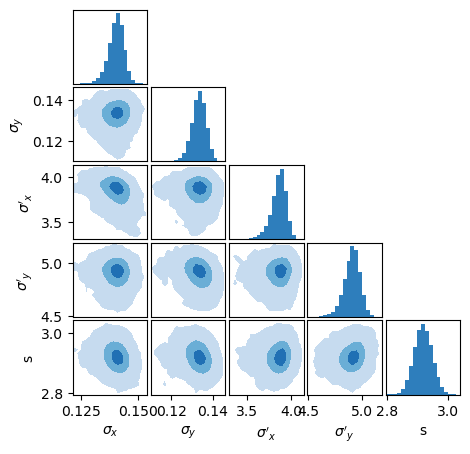

In [11]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.05, 0.45, 0.9, 0.98,  1,]
# levels = [0.5, 1,]
figsize = (5,5)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

## Generate Plot: 

In [12]:
function plot_projections(cv_matrix, event_tr, event_nt, params)
    
    amp_coeff = 1.15
    alpha_1 = 0.025
    alpha_2 = 0.975
    
    median_event = generate_event(params, 
        event_nt.population, cv_matrix; 
        inc_noise=false, 
        size=[size(event_nt.cam_1), size(event_nt.cam_2), size(event_nt.cam_3), size(event_nt.cam_4)], 
        include_satur=false
    )
    
    fig, ax = plt.subplots(4,2, figsize=(12,8))
    fig.subplots_adjust(hspace=0.23, wspace=0.05)
    
    for i in 1:4 
        ycounts_nt = [sum(event_nt[i], dims=1)...]
        ycounts_tr = [sum(event_tr[i], dims=1)...]
        median_sum = [sum(median_event[i], dims=1)...]

        xedges = 1:length(ycounts_tr)

        ax[i,1].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
        ax[i,1].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)

        if i != 4
            fluct = [eval_quantile(conv_matrices[i], j, alpha_min = alpha_1, alpha_max = alpha_2) for j in eachcol(median_event[i])]
            fluct_up = [j[1] for j in fluct] .- median_sum
            fluct_down = median_sum .- [j[2] for j in fluct] 
        else
            fluct = [eval_conv_is(j, params.cam4_light_fluct) for j in eachcol(median_event[i])];
            fluct_up = [quantile(j, 0.975) for j in fluct] .- median_sum
            fluct_down = median_sum .- [quantile(j, 0.025) for j in fluct]
        end

        ax[i,1].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)

        ax[i,1].set_ylim(0, amp_coeff*maximum(ycounts_nt))
        ax[i,1].set_xlim(minimum(xedges), maximum(xedges))

        ycounts_nt = [sum(event_nt[i], dims=2)...]
        ycounts_tr = [sum(event_tr[i], dims=2)...]
        median_sum = [sum(median_event[i], dims=2)...]

        xedges = 1:length(ycounts_tr)

        ax[i,2].step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
        ax[i,2].fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)

        if i != 4
            fluct = [eval_quantile(conv_matrices[i], j, alpha_min = alpha_1, alpha_max = alpha_2) for j in eachrow(median_event[i])]
            fluct_up = [j[1] for j in fluct] .- median_sum
            fluct_down = median_sum .- [j[2] for j in fluct] 
        else
            fluct = [eval_conv_is(j, params.cam4_light_fluct) for j in eachrow(median_event[i])];
            fluct_up = [quantile(j, 0.975) for j in fluct] .- median_sum
            fluct_down = median_sum .- [quantile(j, 0.025) for j in fluct];
        end

        ax[i,2].errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)

        ax[i,2].set_ylim(0, amp_coeff*maximum(ycounts_nt))
        ax[i,2].set_xlim(minimum(xedges), maximum(xedges))

        ax[i,1].set_yticks([])
        ax[i,2].set_yticks([])
    end

    ax[4,1].set_xlabel("x [pixel index]")
    ax[4,2].set_xlabel("y [pixel index]")

    ax[1,1].set_ylabel("Cam. #1")
    ax[2,1].set_ylabel("Cam. #2")
    ax[3,1].set_ylabel("Cam. #3")
    ax[4,1].set_ylabel("Cam. #4")

    fig.text(0.08, 0.5, "Integrated Light Intensity [a.u.]", va="center", rotation="vertical")
end

plot_projections (generic function with 1 method)

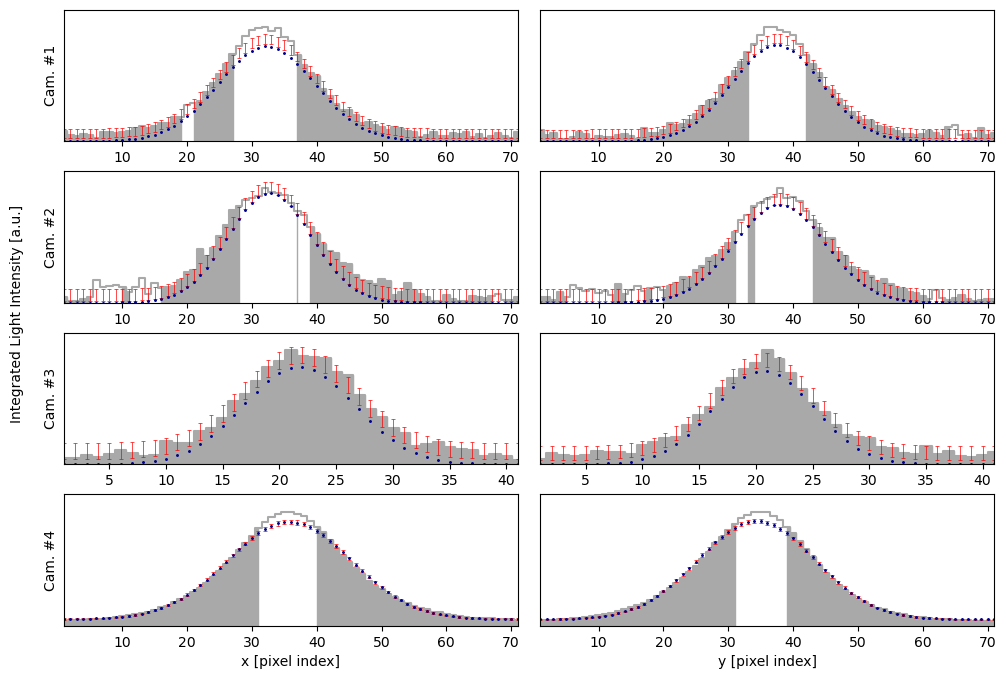

PyObject Text(0.08, 0.5, 'Integrated Light Intensity [a.u.]')

In [13]:
plot_projections(conv_matrices, event, event_nt, mode_params[1])

***

# Generate Simulated Event: 

In [ ]:
# generate event with given parameters: 

median_params = median(samples)[1]

median_event = generate_event(median_params, 
    event.population, conv_matrices; 
    inc_noise=false, 
    size=[size(event.cam_1), size(event.cam_2), size(event.cam_3), size(event.cam_4)], 
    include_satur=false);

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(median_event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(median_event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(median_event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(median_event.cam_4, cmap="RdYlBu_r")

## Simple Example: 

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ycounts_nt = [sum(event_nt[1], dims=1)...]
# ycounts_tr = [nansum(i) for i in eachcol(event[1])]
ycounts_tr =   [sum(event[1], dims=1)...]
median_sum = [sum(median_event[1], dims=1)...]

xedges = 1:length(ycounts_tr)

ax.step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
ax.fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
ax.errorbar(xedges, median_sum, ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)

In [ ]:
fluct = [eval_conv(conv_matrices[1], j) for j in eachcol(median_event[1]) ];

In [ ]:
ind = 10
α1, α2 = 0.025, 0.9995

fluct_up = argmin(abs.(cumsum(fluct[ind]) .- α2)) 
fluct_down = argmin(abs.(cumsum(fluct[ind]) .- α1))
model_value = sum(median_event[1][:, ind])

data_tr = sum(event[1][:, ind])
data_ntr = sum(event_nt[1][:, ind])

# @show fluct_up, fluct_down, data_tr, data_ntr

fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(1:length(fluct[ind]), fluct[ind])

ax.axvline([fluct_up], color="red")
ax.axvline([fluct_down], color="red")
ax.axvline([model_value], linestyle = "--", color="red")

ax.axvline([data_tr], linestyle = ":", color="orange")
ax.axvline([data_ntr], linestyle = "--", alpha=0.5, color="gray")

ax.set_xlim(0, 10000);

# Example: Cam 1

In [ ]:
cam_ind = 1
cam_proj = 1

In [ ]:
ycounts_nt = [sum(event_nt[cam_ind], dims=cam_proj)...]
ycounts_tr =   [sum(event[cam_ind], dims=cam_proj)...]
median_sum = [sum(median_event[cam_ind], dims=cam_proj)...]
fluct = [eval_quantile(conv_matrices[cam_ind], j) for j in eachcol(median_event[cam_ind])]; # col for proj 1 
# fluct = [eval_quantile(conv_matrices[cam_ind], j) for j in eachrow(median_event[cam_ind])];

In [ ]:
fluct_up = [i[1] for i in fluct] .- median_sum
fluct_down = median_sum .- [i[2] for i in fluct] ;

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

xedges = 1:length(ycounts_tr)

ax.step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
ax.fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
ax.errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)

## Cam 4: 

In [ ]:
cam_ind = 4
cam_proj = 1

In [ ]:
ycounts_nt = [sum(event_nt[cam_ind], dims=cam_proj)...]
ycounts_tr =   [sum(event[cam_ind], dims=cam_proj)...]
median_sum = [sum(median_event[cam_ind], dims=cam_proj)...]
fluct = [eval_conv_is(j) for j in eachcol(median_event[cam_ind])];
# fluct = [eval_conv_is(j) for j in eachrow(median_event[cam_ind])];

In [ ]:
fluct_up = [quantile(j, 0.975) for j in fluct] .- median_sum
fluct_down = median_sum .- [quantile(j, 0.025) for j in fluct];

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

xedges = 1:length(ycounts_tr)

ax.step(xedges, ycounts_nt, color="darkgray", where="mid", zorder=0)
ax.fill_between(xedges, ycounts_tr, step="mid", color="darkgray", alpha=1)
ax.errorbar(xedges, median_sum, yerr=[fluct_down, fluct_up], ms=2.2, fmt=".", color="darkblue", ecolor="red",  capthick=0.5, capsize=1.5, linewidth=0.5)